In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fact_full = pd.read_excel('.\Data\Descarga_FACTURADO_CLIENTES_NB_240823.xlsx',skiprows=1)
df_fact = fact_full.groupby(by = 'Periodo', sort = True)['Suma Total'].sum().reset_index()
df_fact.rename(columns={'Periodo': 'mes', 'Suma Total': 'fact'}, inplace = True)
df_fact.set_index('mes', inplace = True)
df_fact.head()

,fact
mes,
2019-01-01,22150781.76
2019-02-01,20681481.53
2019-03-01,22316953.30
2019-04-01,22943028.41
2019-05-01,22975503.75


In [3]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
df_vent = df_vent.sort_values(by = 'mes')
df_vent.set_index('mes', inplace = True)
df_vent.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [4]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc.head()

,ipc
fecha,
2016-12-01,100.0000
2017-01-01,101.5859
2017-02-01,103.6859
2017-03-01,106.1476
2017-04-01,108.9667


In [5]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [6]:
df_retail = vent_full[vent_full['Razón Social'] != 'GD WORK SA']
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
df_retail.set_index('mes', inplace = True)
df_retail.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [7]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,ventas
mes,
2019-01-01,824754.21
2019-02-01,983820.43
2019-03-01,1281202.80
2019-04-01,2000058.99
2019-05-01,1787994.13


In [8]:
#df_ipc.reset_index(inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
#df_ipc.set_index

In [9]:

def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

In [10]:
df_vent = filtrar_serie(df_vent, '2017-01-01', '2023-08-01')
df_retail = filtrar_serie(df_retail, '2017-01-01', '2023-08-01')
df_cowork = filtrar_serie(df_cowork, '2017-01-01', '2023-08-01')
df_usd = filtrar_serie(df_usd, '2017-01-01', '2023-08-01')

In [11]:
def corregir_usd_ipc(serie, ipc, dolar):
    corregida = serie / (1 + ipc)
    corregida = corregida / dolar
    return corregida

In [12]:
df_vent['ventas_ajustado'] = corregir_usd_ipc(df_vent['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_cowork['ventas_ajustado'] = corregir_usd_ipc(df_cowork['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_retail['ventas_ajustado'] = corregir_usd_ipc(df_retail['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])

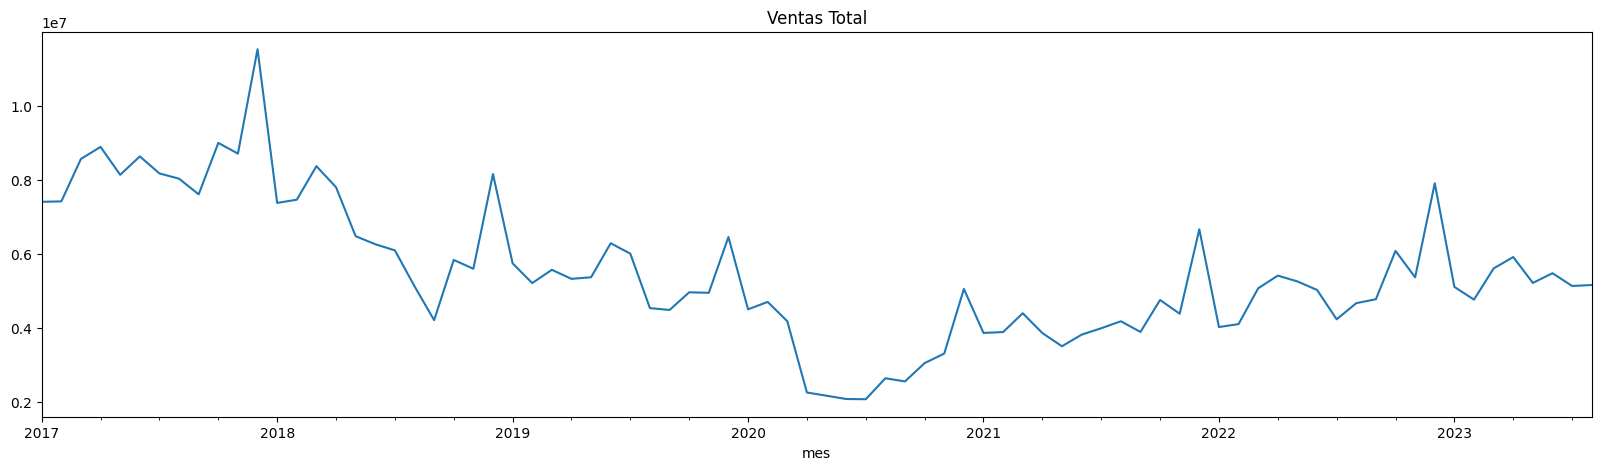

In [18]:
df_vent.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Total")
plt.show()

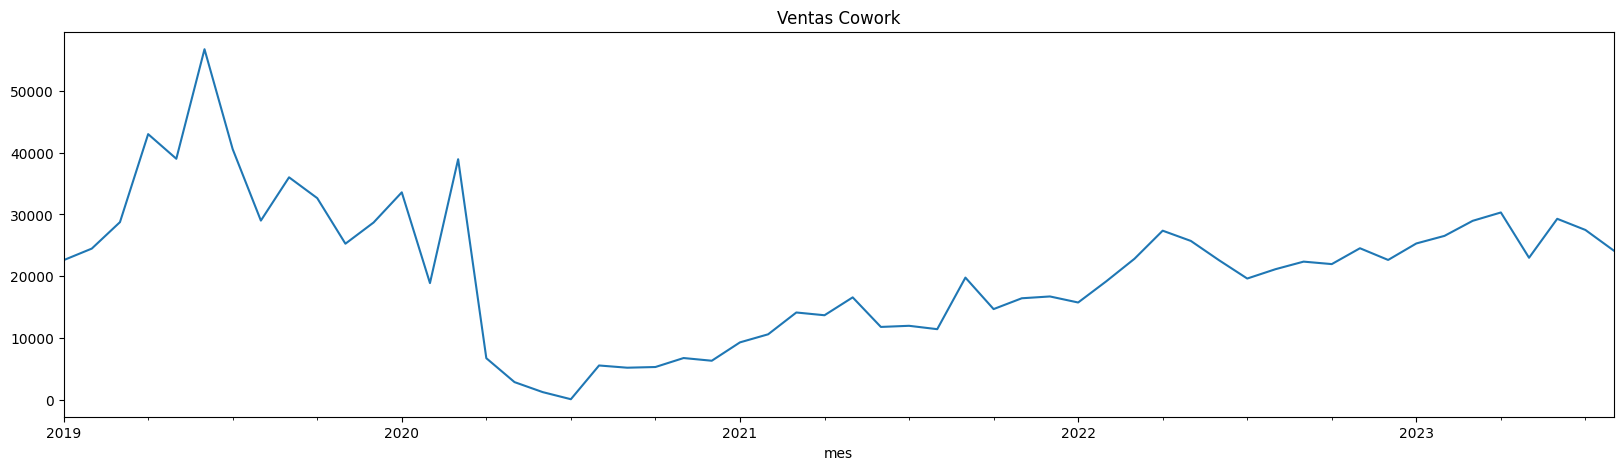

In [19]:
df_cowork.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Cowork")
plt.show()

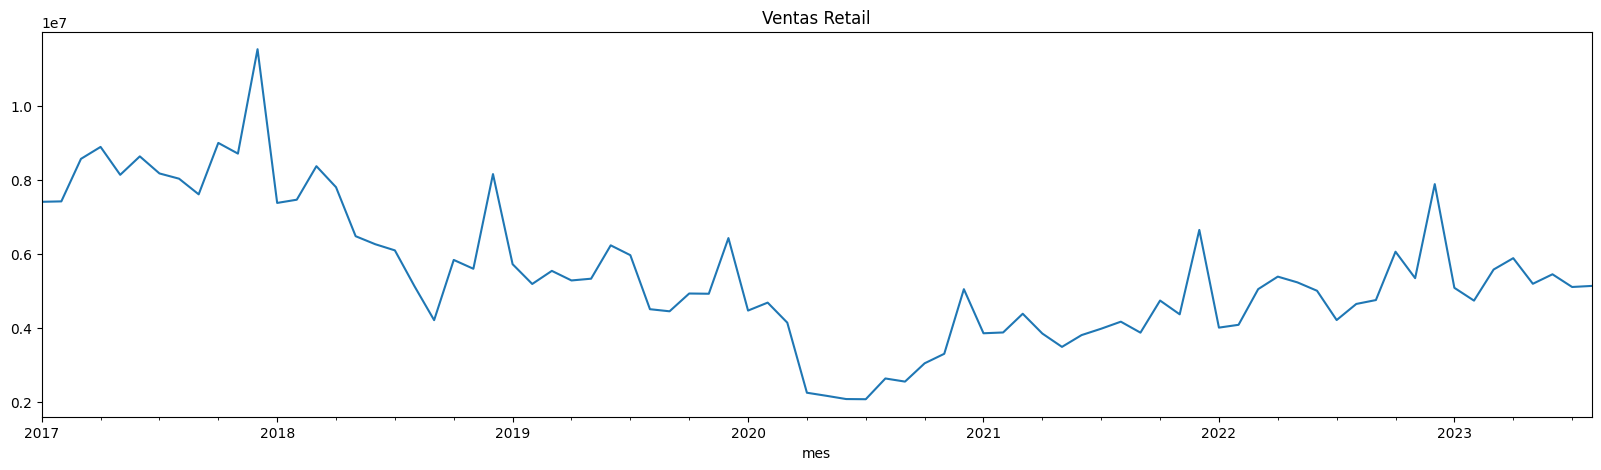

In [20]:
df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()